# Prediction of Future User Adoption

## Introduction

The data is available as two attached CSV files: 'takehome_user_engagement.csv' and 'takehome_users.csv'.<br>
The data has the following two tables:<br><br>
<b>1-</b> A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years. This table includes:<br>
<ul> 
<li><b>name:</b> the user's name</li>
<li> <b>object_id: </b>the user's id</li>
<li> <b>email:</b> email address</li>
<li> <b>creation_source:</b> how their account was created. This takes on one
of 5 values:
<ul>
<li>PERSONAL_PROJECTS: invited to join another user's personal workspace</li>
<li> GUEST_INVITE: invited to an organization as a guest (limited permissions)</li>
<li>ORG_INVITE: invited to an organization (as a full member)</li>
<li> SIGNUP: signed up via the website</li>
<li> SIGNUP_GOOGLE_AUTH: signed up using Google</li>
<li>Authentication (using a Google email account for their login
id)</li></ul>
<li> <b>creation_time:</b> when they created their account</li>
<li> <b>last_session_creation_time:</b> unix timestamp of last login</li>
<li><b> opted_in_to_mailing_list:</b> whether they have opted into receiving marketing emails</li>
<li> <b>enabled_for_marketing_drip:</b> whether they are on the regular marketing email drip</li>
<li> <b>org_id:</b> the organization (group of users) they belong to</li>
<li> <b>invited_by_user_id:</b> which user invited them to join (if applicable).</li></ul><br>
<b>2-</b> A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product.

## Objective

<ul><li>Define an "adopted user" as a user who has logged into the product on three separate days in at least one seven day period,</li><li>Identify which factors predict future user adoption.</li></ul>

In [1]:
# importing necessary packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## Users Data

In [2]:
# reading the user table data encoding it to 'latin-1', otherwise it fails to read the data
users = pd.read_csv('takehome_users.csv', encoding='latin-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
# obtaining information about the data
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


There are missing values in last_session_creation_time, invited_by_user_id columns.There are also inconsistent data types. For example creation_time column values need to be in the datetime format or invited_by_user_id column values should be integers. 

In [4]:
# changing columns to appropriate data types
users.creation_time = pd.to_datetime(users['creation_time'])
users.last_session_creation_time = pd.to_datetime(users['last_session_creation_time'], unit='s')

## User Engagement Data

In [5]:
# reading the user engagement table data 
user_eng = pd.read_csv('takehome_user_engagement.csv')
user_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
# obtaining information about the data
user_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
# changing columns to appropriate data types
user_eng['time_stamp'] = pd.to_datetime(user_eng['time_stamp'])

## Determining Adopted Users

In [8]:
# determining number of visits by user in a week
visits = user_eng.groupby(['user_id', pd.Grouper(key='time_stamp', freq='W')])[['visited']].count()
#=user_eng['week/year'] = user_eng['time_stamp'].apply(lambda x: "%d/%d"% (x.week, x.year))
visits = visits.reset_index()

# getting weekly count max per user
max_visits = visits.groupby('user_id')['visited'].max()
max_visits = max_visits.reset_index()

# determining adopted users
max_visits['adopted'] = np.where(max_visits['visited'] >= 3, 1, 0)
max_visits.head()

,user_id,visited,adopted
0,1,1,0
1,2,3,1
2,3,1,0
3,4,1,0
4,5,1,0


## Data Wrangling

In [9]:
# merging two dataframes
users.rename({'object_id':'user_id'},inplace=True,axis=1)
df = pd.merge(users, max_visits, on='user_id',  how='outer')
# filling the NaN values in the adopted column with zeros since those users did not log into the product at all
df['adopted'] = df['adopted'].fillna(0)
df['visited'] = df['visited'].fillna(0)
df['last_session_creation_time'] = df['last_session_creation_time'].fillna(0)
df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,3.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,1.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,1.0,0.0


In [10]:
df['adopted'].value_counts()

0.0    10555
1.0     1445
Name: adopted, dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
user_id                       12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
visited                       12000 non-null float64
adopted                       12000 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 1.2+ MB


### Processsing Categorical Data

In [12]:
# making dummy variable for creation source column
data = pd.get_dummies(df, prefix=['cr_s'], columns=['creation_source'])

# creating a column showing if the user is invited by another user or not 
data['invited_by_user_id'] = np.where(df['invited_by_user_id'] > 0, 1, 0)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 16 columns):
user_id                       12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
last_session_creation_time    12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null int64
visited                       12000 non-null float64
adopted                       12000 non-null float64
cr_s_GUEST_INVITE             12000 non-null uint8
cr_s_ORG_INVITE               12000 non-null uint8
cr_s_PERSONAL_PROJECTS        12000 non-null uint8
cr_s_SIGNUP                   12000 non-null uint8
cr_s_SIGNUP_GOOGLE_AUTH       12000 non-null uint8
dtypes: datetime64[ns](1), float64(2), int64(5), object(3),

In [14]:
len(data['org_id'].unique())

417

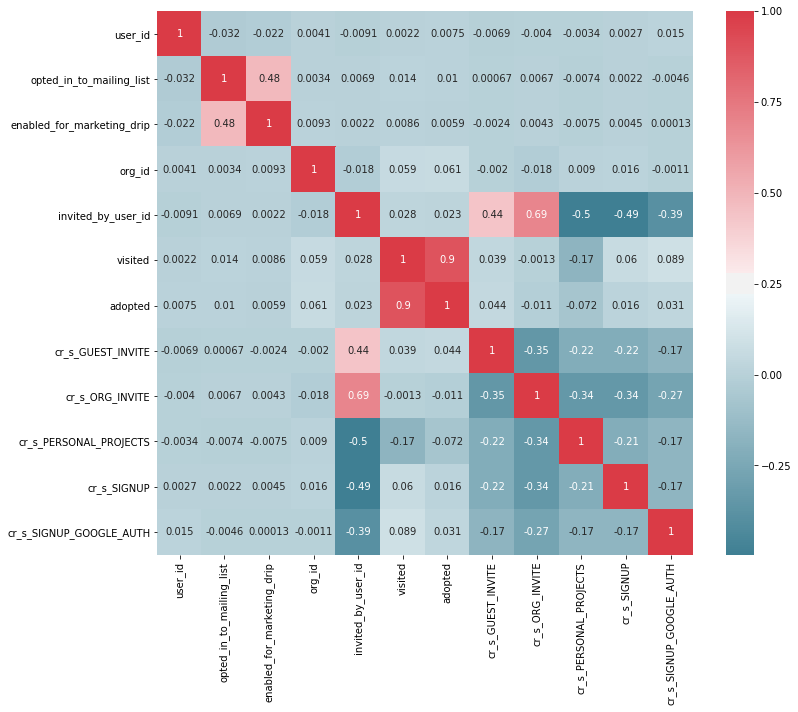

In [15]:
cor = data.corr()
plt.figure(figsize = (12,10))
ax = sns.heatmap(cor, annot = True, cmap=sns.diverging_palette(220, 10, as_cmap=True))
_ = ax.set_xlim(0, 12)
_ = ax.set_ylim(12, 0)

In [16]:
data.head()

,user_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,adopted,cr_s_GUEST_INVITE,cr_s_ORG_INVITE,cr_s_PERSONAL_PROJECTS,cr_s_SIGNUP,cr_s_SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,2014-04-22 03:53:30,1,0,11,1,1.0,0.0,1,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,2014-03-31 03:45:04,0,0,1,1,3.0,1.0,0,1,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,2013-03-19 23:14:52,0,0,94,1,1.0,0.0,0,1,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,2013-05-22 08:09:28,0,0,1,1,1.0,0.0,1,0,0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,2013-01-22 10:14:20,0,0,193,1,1.0,0.0,1,0,0,0,0


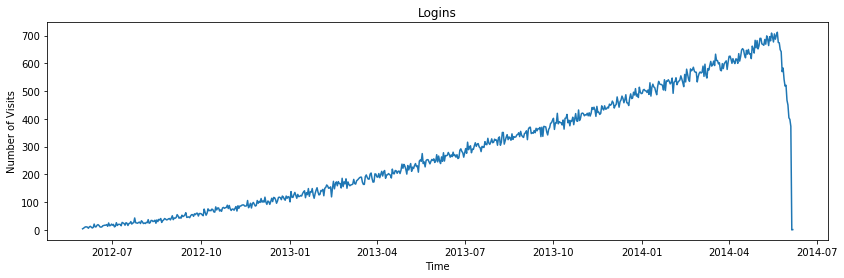

In [17]:
time = user_eng.copy()
time = time.set_index('time_stamp').resample('D').sum()
time = time.reset_index()
fig, ax = plt.subplots(figsize = (14,4))
plt.xlabel('Time')
plt.ylabel('Number of Visits')
plt.title('Logins')
plt.plot(time.time_stamp, time.visited)
plt.style.use('ggplot')

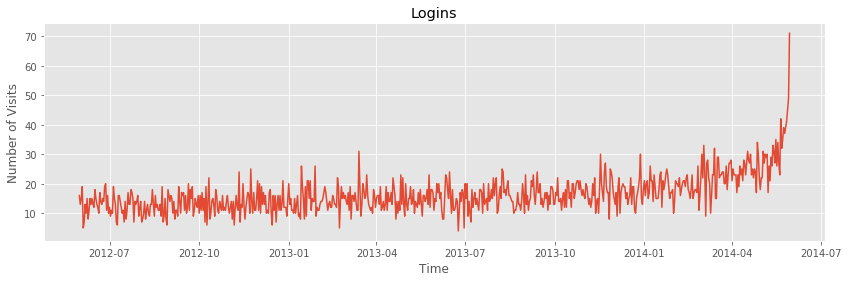

In [18]:
t = users.copy()
t = t[['creation_time', 'last_session_creation_time']]
t['freq'] = 1
t = t.set_index('creation_time').resample('D').sum()
t = t.reset_index()
fig, ax = plt.subplots(figsize = (14,4))
plt.xlabel('Time')
plt.ylabel('Number of Visits')
plt.title('Logins')
plt.plot(t.creation_time, t.freq)
plt.style.use('ggplot')

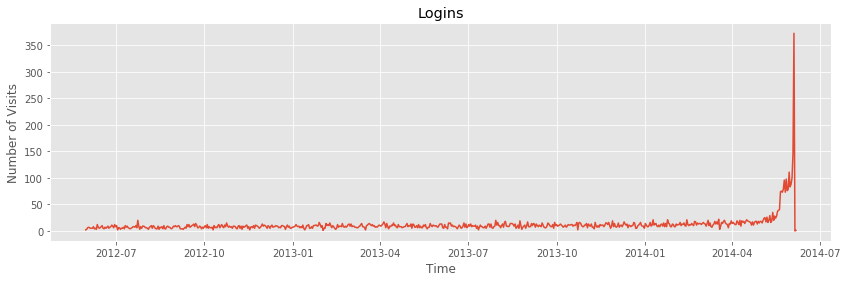

In [19]:
t = users.copy()
t = t[['creation_time', 'last_session_creation_time']]
t['freq'] = 1
t = t.set_index('last_session_creation_time').resample('D').sum()
t = t.reset_index()
fig, ax = plt.subplots(figsize = (14,4))
plt.xlabel('Time')
plt.ylabel('Number of Visits')
plt.title('Logins')
plt.plot(t.last_session_creation_time, t.freq)
plt.style.use('ggplot')

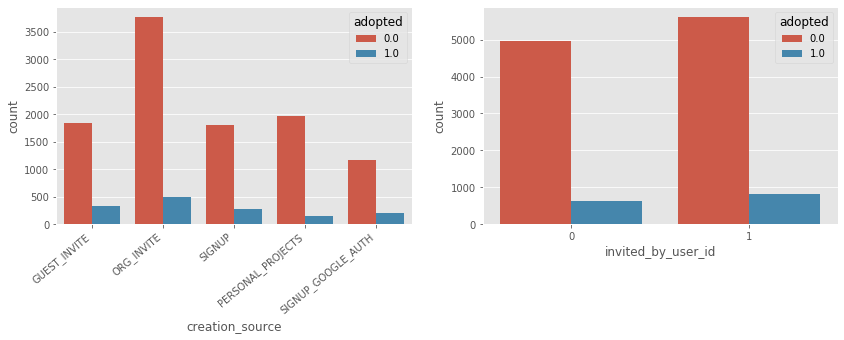

In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(14,4))

# Creation source and adopted user
ax1 = sns.countplot(x='creation_source', data=df, hue='adopted', ax=axs[0])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right")
ax2= sns.countplot(x='invited_by_user_id', data=data, hue='adopted', ax=axs[1])

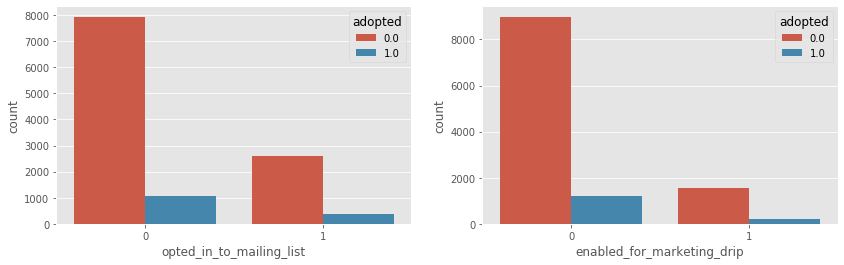

In [21]:
fig, axs = plt.subplots(ncols=2, figsize=(14,4))
ax3= sns.countplot(x='opted_in_to_mailing_list', data=data, hue='adopted', ax=axs[0])
ax4= sns.countplot(x='enabled_for_marketing_drip', data=data, hue='adopted', ax=axs[1])

### Up-sample Minority Class

In [22]:
df_final = data[[ 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'invited_by_user_id', 'adopted',
       'cr_s_ORG_INVITE', 'cr_s_PERSONAL_PROJECTS', 'cr_s_SIGNUP', 'cr_s_SIGNUP_GOOGLE_AUTH']]

# importing module for resampling
from sklearn.utils import resample

# Separate majority and minority classes
df_final_majority = df_final[df_final.adopted==0]
df_final_minority = df_final[df_final.adopted==1]
 
# Upsample minority class
df_final_minority_upsampled = resample(df_final_minority, 
                                 replace=True,                        # sample with replacement
                                 n_samples=len(df_final_majority),    # to match majority class
                                 random_state=123)                    # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_final_majority, df_final_minority_upsampled])
 
# Display new class counts
df_upsampled.adopted.value_counts()

1.0    10555
0.0    10555
Name: adopted, dtype: int64

## Model Prediction

In [23]:
df_upsampled.columns

Index(['opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'invited_by_user_id', 'adopted', 'cr_s_ORG_INVITE',
       'cr_s_PERSONAL_PROJECTS', 'cr_s_SIGNUP', 'cr_s_SIGNUP_GOOGLE_AUTH'],
      dtype='object')

## Random Forest 

In [24]:
from sklearn.model_selection import train_test_split

#set up data by seperating out the labels, then split for cross validation
features = df_upsampled.drop('adopted', axis=1)
target = df_upsampled['adopted']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

In [25]:
from sklearn.ensemble import RandomForestClassifier

#train and test classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

print('Accuracy score on train set:', rf.score(X_train, y_train))
print('Accuracy score on test set:', rf.score(X_test, y_test))

Accuracy score on train set: 0.5544427150301143
Accuracy score on test set: 0.5532922785409758


In [26]:
# printing the classification report
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.57      0.47      0.51      3214
         1.0       0.54      0.64      0.59      3119

    accuracy                           0.55      6333
   macro avg       0.56      0.55      0.55      6333
weighted avg       0.56      0.55      0.55      6333



### Hyperparameter Tuning

In [27]:
from sklearn.model_selection import GridSearchCV
# Tune hyperparameters in decision tree classifier using GridSearchCV
# Setup the parameters and distributions to sample from: param_grid

param_grid = {"max_depth": [3, 5, 7],
              "max_features": [1,2,3,4],
              "min_samples_leaf": [0.1,1,2],
              "criterion": ["gini", "entropy"]}

# Instantiate the GridSearchCV object
grid_cv = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)

# Fit to training data
grid_cv.fit(X_train, y_train)   

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(grid_cv.best_params_))
print("Best CV score is {}".format(grid_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 2, 'min_samples_leaf': 1}
Best CV score is 0.5544427150301143


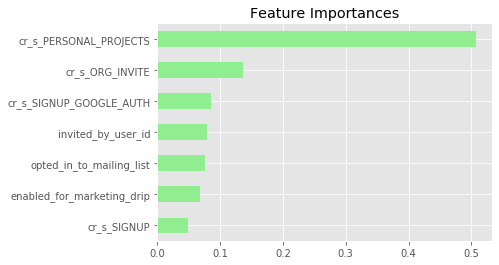

In [28]:
# Create series of the features importances and sort the values
importances = pd.Series(rf.feature_importances_, index=['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 
        'invited_by_user_id', 'cr_s_ORG_INVITE', 'cr_s_PERSONAL_PROJECTS', 
        'cr_s_SIGNUP', 'cr_s_SIGNUP_GOOGLE_AUTH']).sort_values()

# Visualize the ranked importance of the features in a horizontal bar plot
importances.plot(kind='barh', color='lightgreen')
plt.title('Feature Importances')
plt.show();

## XGBoost

In [29]:
from xgboost import XGBClassifier
xg = XGBClassifier()
xg.fit(X_train, y_train)

print('Accuracy score on train set:', xg.score(X_train, y_train))
print('Accuracy score on test set:', xg.score(X_test, y_test))

Accuracy score on train set: 0.5544427150301143
Accuracy score on test set: 0.5532922785409758


In [30]:
# printing the classification report
print(classification_report(y_test, xg.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.57      0.47      0.51      3214
         1.0       0.54      0.64      0.59      3119

    accuracy                           0.55      6333
   macro avg       0.56      0.55      0.55      6333
weighted avg       0.56      0.55      0.55      6333



In [31]:
# Tune hyperparameters in decision tree classifier using GridSearchCV
# Setup the parameters and distributions to sample from: param_grid
import xgboost as xgb
param_grid_xgb= {"learning_rate": [0.01, 0.1, 0.3],
              "n_estimators": [10, 20, 50],
              "subsample": [0.3, 0.5,0.9]}
xgb_ = xgb.XGBClassifier(random_state=1)

# Instantiate the GridSearchCV object
grid_cv = GridSearchCV(estimator=xgb_, param_grid = param_grid_xgb, cv=4)

# Fit to training data
grid_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(grid_cv.best_params_))
print("Best CV score is {}".format(grid_cv.best_score_))

Tuned Decision Tree Parameters: {'learning_rate': 0.3, 'n_estimators': 50, 'subsample': 0.9}
Best CV score is 0.5544427150301143


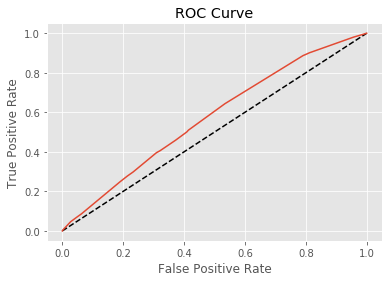

In [32]:
# Import necessary modules 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Compute predicted probabilities: y_pred_prob
y_pred_prob = xg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [33]:
# Compute and print AUC score
#print("Area under the ROC curve roc_auc_score(y_test, y_pred_prob))

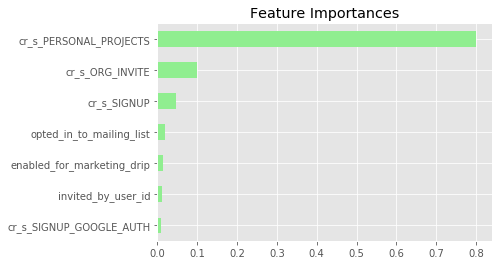

In [34]:
# Create series of the features importances and sort the values
importances = pd.Series(xg.feature_importances_, index=['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 
        'invited_by_user_id', 'cr_s_ORG_INVITE', 'cr_s_PERSONAL_PROJECTS', 
        'cr_s_SIGNUP', 'cr_s_SIGNUP_GOOGLE_AUTH']).sort_values()

# Visualize the ranked importance of the features in a horizontal bar plot
importances.plot(kind='barh', color='lightgreen')
plt.title('Feature Importances')
plt.show();